Disease Prediction from Medical Data (Diabetes)

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


LOADING AND EXPLORING DATASET

In [3]:

from google.colab import files
uploaded = files.upload()

df = pd.read_csv("diabetes.csv")
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nMissing values:\n", df.isnull().sum())
print("\nDescriptive Stats:\n", df.describe())

Shape: (768, 9)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Missing values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigr

VISUALIZE DATA

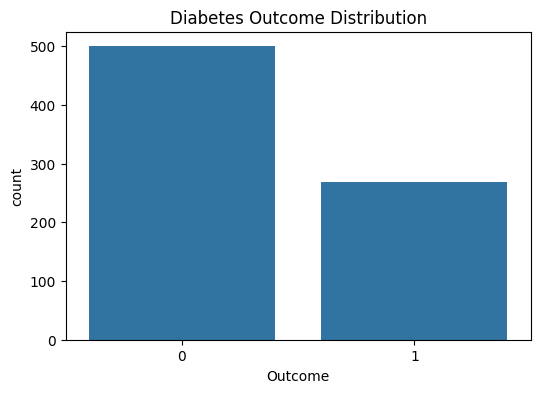

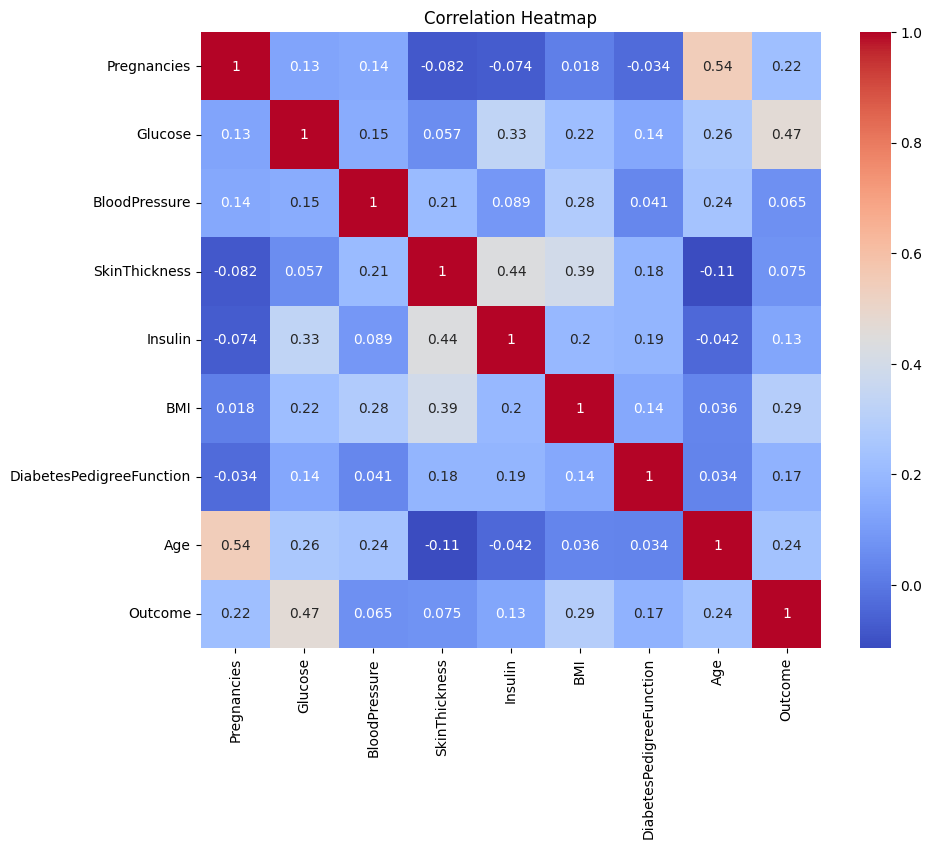

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x='Outcome', data=df)
plt.title("Diabetes Outcome Distribution")
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

DATA PREPROCESSING

In [6]:

cols_with_zero = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

df[cols_with_zero] = df[cols_with_zero].fillna(df[cols_with_zero].mean())

X = df.drop("Outcome", axis=1)
y = df["Outcome"]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


DATA SPLIT

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 614
Testing samples: 154


TRAINING MODELS

In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42)
}

trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

MODEL EVALUATION

In [12]:

from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in trained_models.items():
    acc = cross_val_score(model, X_scaled, y, cv=cv, scoring="accuracy").mean()
    prec = cross_val_score(model, X_scaled, y, cv=cv, scoring="precision").mean()
    rec = cross_val_score(model, X_scaled, y, cv=cv, scoring="recall").mean()
    f1 = cross_val_score(model, X_scaled, y, cv=cv, scoring="f1").mean()
    auc = cross_val_score(model, X_scaled, y, cv=cv, scoring="roc_auc").mean()

    results.append([name, acc, prec, rec, f1, auc])

results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1-Score","ROC-AUC"])
results_df


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.773389,0.726511,0.574703,0.638829,0.836361
1,SVM,0.752551,0.685197,0.548498,0.607602,0.822669
2,Random Forest,0.762966,0.684685,0.604612,0.640585,0.822355
3,XGBoost,0.725202,0.613433,0.574493,0.591967,0.792546


MODEL SELECTION

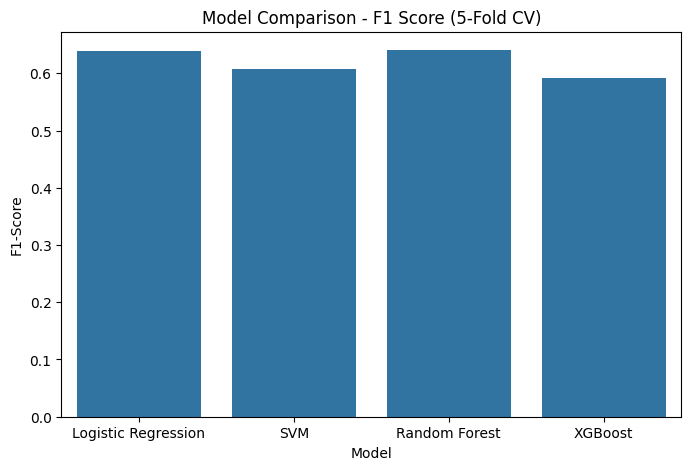

Best Model based on F1-Score: Random Forest


In [13]:
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="Model", y="F1-Score")
plt.title("Model Comparison - F1 Score (5-Fold CV)")
plt.show()

best_model_name = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]["Model"]
print("Best Model based on F1-Score:", best_model_name)

MODEL COMPARISON

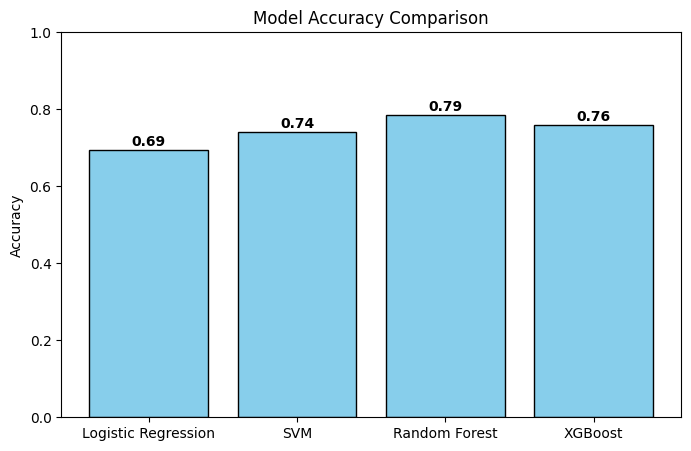

In [20]:
# Compare model accuracies
model_names = list(trained_models.keys())
accuracies = [accuracy_score(y_test, trained_models[m].predict(X_test)) for m in model_names]

plt.figure(figsize=(8,5))
plt.bar(model_names, accuracies, color="skyblue", edgecolor="black")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha="center", fontsize=10, fontweight="bold")
plt.show()


MODEL SELECTION AND SAMPLE PREDICTIONS

Best Model Selected: Random Forest

Classification Report:

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       100
           1       0.72      0.63      0.67        54

    accuracy                           0.79       154
   macro avg       0.77      0.75      0.76       154
weighted avg       0.78      0.79      0.78       154



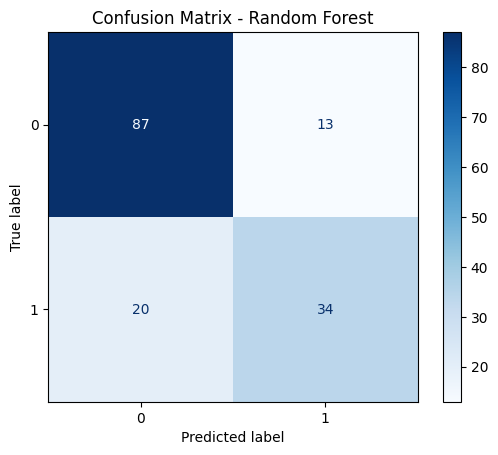


Sample Predictions:
Patient 1: Likely Diabetes | Probabilities -> No Diabetes: 0.31, Diabetes: 0.69
Patient 2: Likely No Diabetes | Probabilities -> No Diabetes: 0.83, Diabetes: 0.17
Patient 3: Likely No Diabetes | Probabilities -> No Diabetes: 0.89, Diabetes: 0.11
Patient 4: Likely No Diabetes | Probabilities -> No Diabetes: 0.74, Diabetes: 0.26
Patient 5: Likely No Diabetes | Probabilities -> No Diabetes: 0.92, Diabetes: 0.08


In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


print(f"Best Model Selected: {best_model_name}\n")

print("Classification Report:\n")
print(classification_report(y_test, y_pred_best))


cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()


samples = X_test[:5]
predictions = best_model.predict(samples)
probabilities = best_model.predict_proba(samples)

print("\nSample Predictions:")
for i, (pred, probs) in enumerate(zip(predictions, probabilities)):
    status = "Likely Diabetes" if pred == 1 else "Likely No Diabetes"
    print(f"Patient {i+1}: {status} | Probabilities -> No Diabetes: {probs[0]:.2f}, Diabetes: {probs[1]:.2f}")


In this project, I built a disease prediction system using structured medical data. I applied multiple machine learning algorithms (Logistic Regression, SVM, Random Forest, XGBoost) and compared their performance. After evaluation, the best-performing model was selected. The results include accuracy metrics, confusion matrix, and sample predictions for patients, showing the probability of having diabetes. This project enhanced my understanding of data preprocessing, model evaluation, and practical application of ML in healthcare.